## **<u>Data Loading</u>**

In [1]:
# Libraries
import os
import glob
import tifffile as tiff
from PIL import Image
import imageio.v2 as imageio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.random_projection import SparseRandomProjection

In [2]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tifffile

Note: you may need to restart the kernel to use updated packages.


In [4]:
file_path = "C:/Users/jatin/Desktop/Sem 3/Internship/RA-AIHI/Assignments/T1/SS-160/160/08_04_SS_T0_Fibro_with_Fibrillarin_63x_4x4_3rdScan_c0_g000.tif"
img_1 = tiff.imread(file_path)
print(img_1.shape)

(38, 1024, 1024)


## **<u>Data Examine</u>**

In [5]:
# Displaying Slicing
def display_slice(slice_num):
    plt.imshow(img_1[slice_num], cmap='gray')
    plt.title(f'Slice {slice_num}')
    plt.axis('off')
    plt.show()

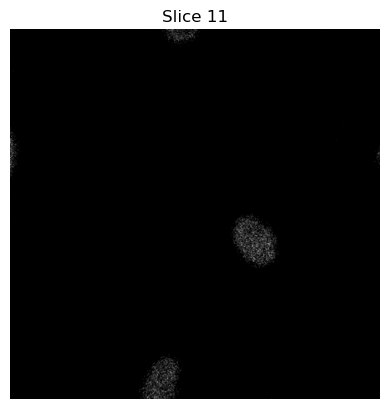

In [6]:
display_slice(11)

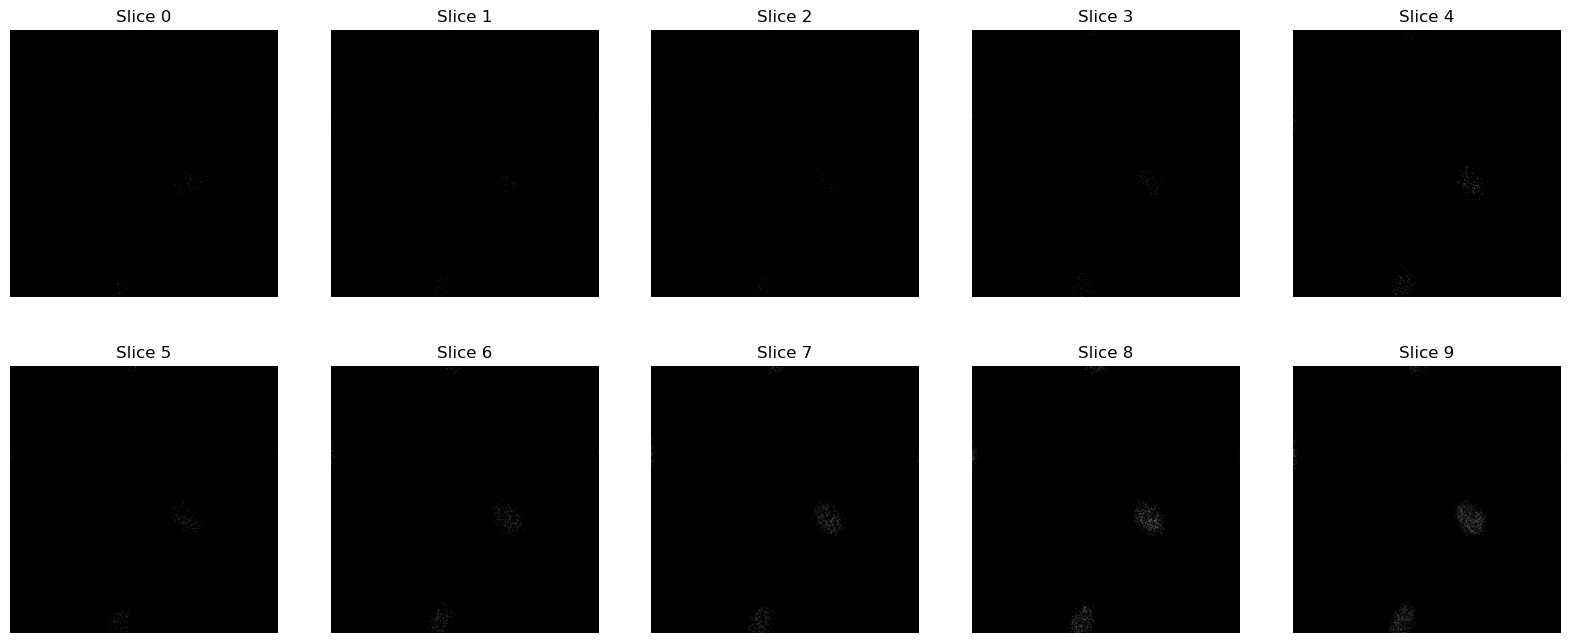

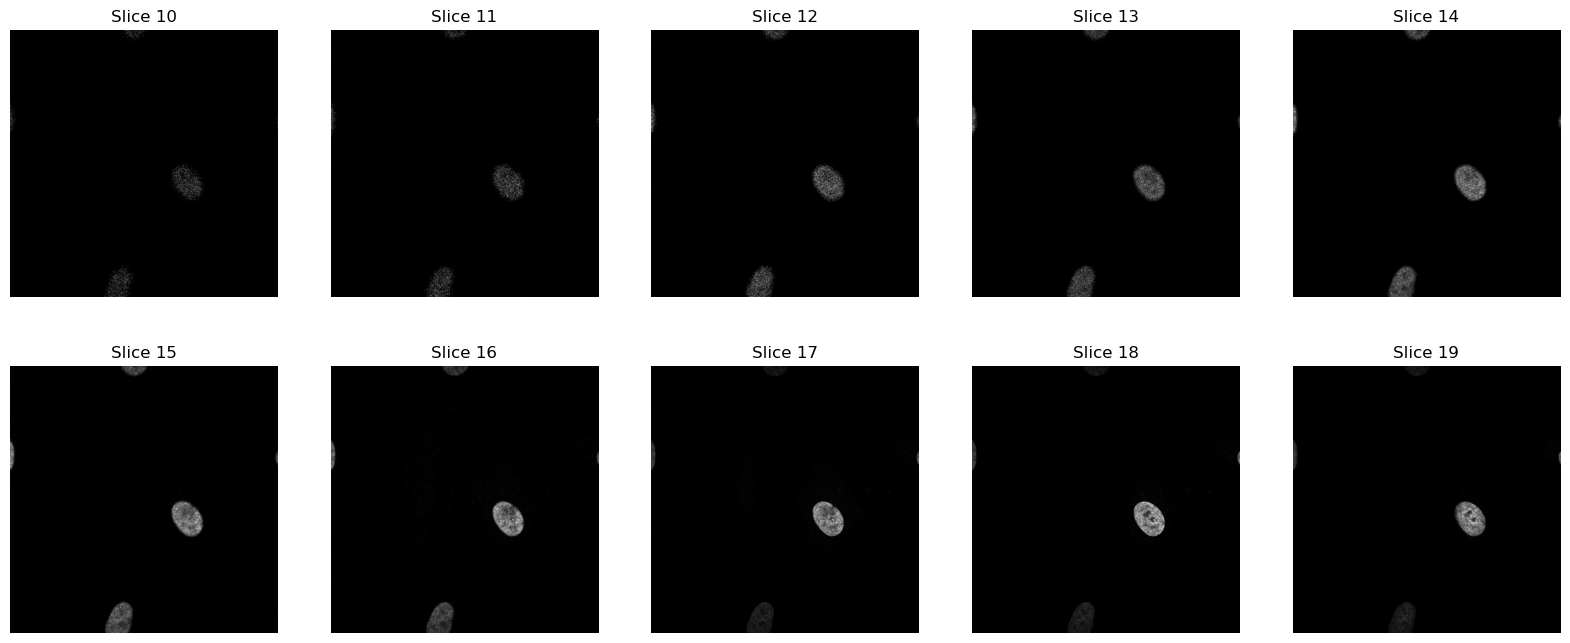

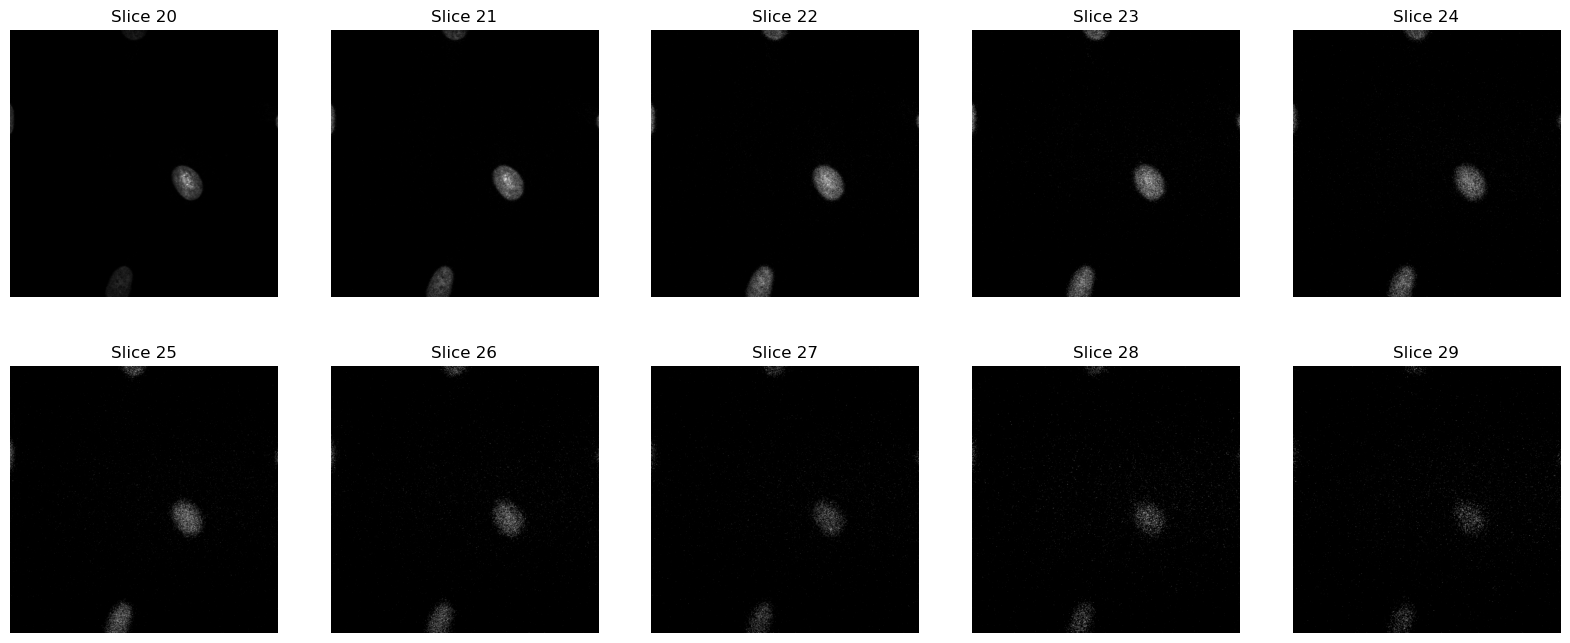

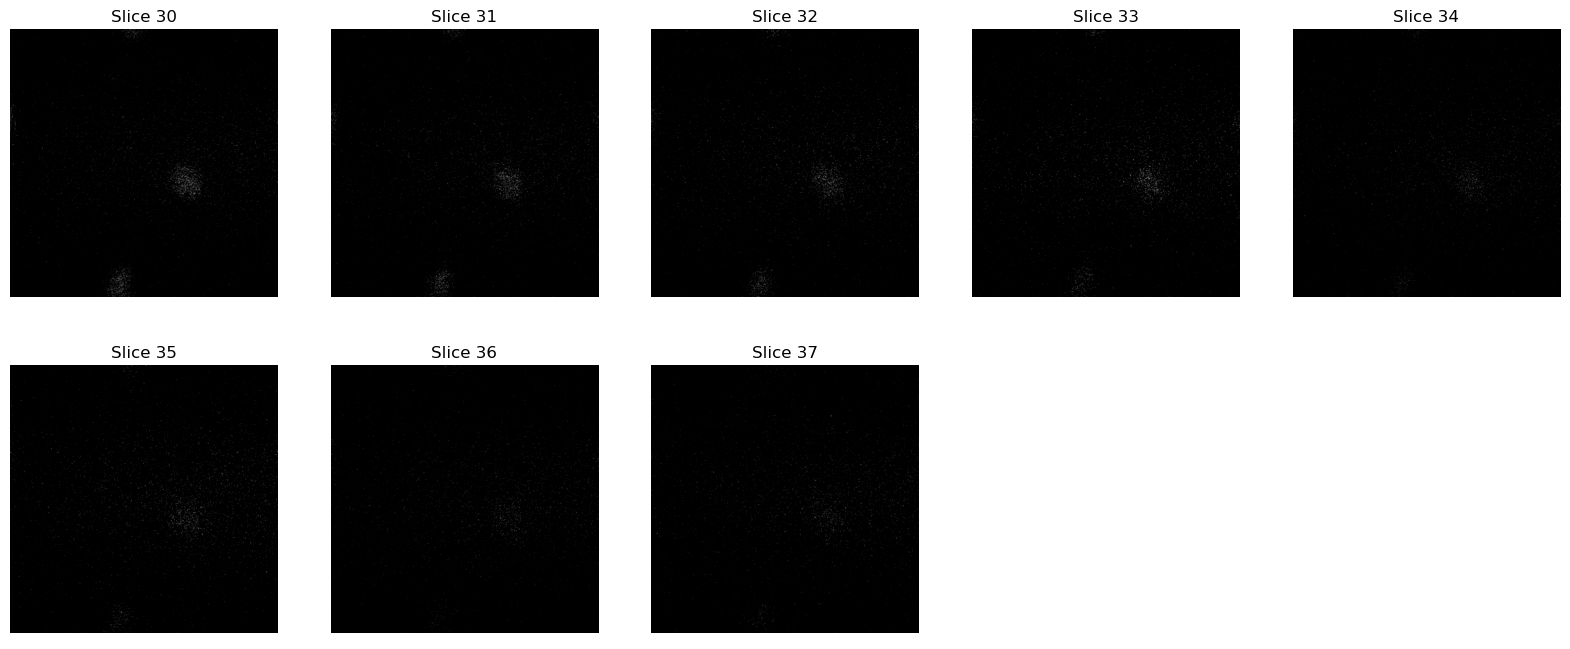

In [7]:
def plot_slices(img_3d, slice_indices, slices_per_row=5):
    num_slices = len(slice_indices)
    num_rows = (num_slices + slices_per_row - 1) // slices_per_row  # Find how many rows are needed
    fig, axs = plt.subplots(num_rows, slices_per_row, figsize=(20, 4 * num_rows))  # Adjust figsize as necessary

    for i, ax in enumerate(axs.flat):
        if i < num_slices:
            ax.imshow(img_3d[slice_indices[i]], cmap='gray')
            ax.set_title(f'Slice {slice_indices[i]}')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide unused axes

def plot_slices_batch(img_3d, batch_size=10):
    num_slices = img_3d.shape[0]
    for start_idx in range(0, num_slices, batch_size):
        end_idx = min(start_idx + batch_size, num_slices)
        plot_slices(img_3d, range(start_idx, end_idx), slices_per_row=5)

plot_slices_batch(img_1, batch_size=10)


In [8]:
# Figuring high intensity of the image
tif_image = img_1
print("3D image px value range:", np.min(tif_image), "to", np.max(tif_image))

3D image px value range: 0 to 217


We are getting a range of **0** to **217** pixels among the slices of the 3D image we loaded. 

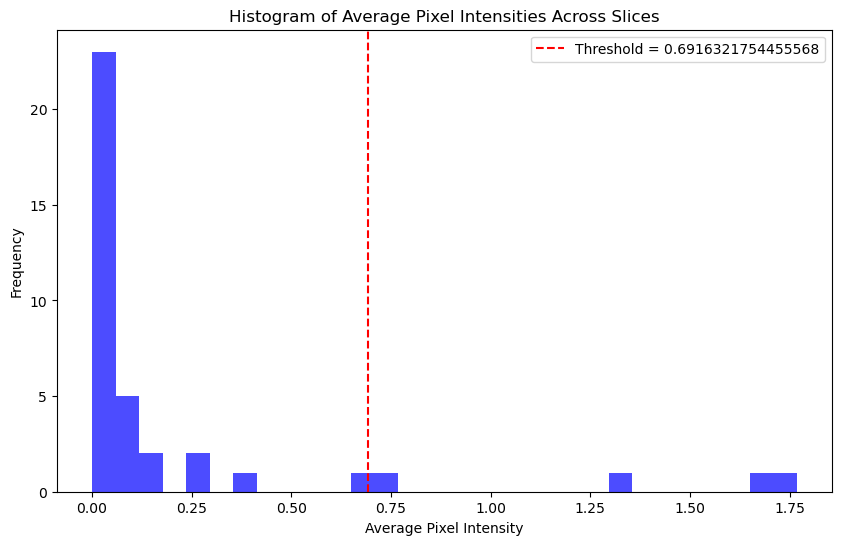

In [9]:
# Calculate average intensities
avg_intensities = [np.mean(img_1[i]) for i in range(img_1.shape[0])]
thr= np.percentile(avg_intensities, 90)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(avg_intensities, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Average Pixel Intensities Across Slices')
plt.xlabel('Average Pixel Intensity')
plt.ylabel('Frequency')
plt.axvline(x=thr, color='red', linestyle='--', label=f'Threshold = {thr}')
plt.legend()
plt.show()

#### ***Code Explaination:***

**1. Calculating Average Intensities:** Imagine you have a bookshelf, where each book represents a slice of your 3D image. Each page of a book (slice) has various shades of grey (pixel intensities). What you're doing here is flipping through each book (slice) and calculating the average shade of grey (pixel intensity) of its pages (pixels). The `avg_intensities` list will then contain the average shade of grey for each book on your shelf.
```
avg_intensities = [np.mean(img_1[i]) for i in range(img_1.shape[0])]
```

**2. Determining the Threshold:** Now, imagine you want to separate the really dark books from the lighter ones. You decide that the "dark" books are those darker than 90% of all the books on the shelf. The `np.percentile(avg_intensities, 90)` function finds that shade of grey which is darker than 90% of all your books, and that’s your threshold `thr`.
```
thr = np.percentile(avg_intensities, 90)
```

**3. Plotting the Histogram:** Here, you're making a chart to see how many books fall into different categories of darkness. You create 30 categories (bins), and for each category, you count how many books belong there. It's like sorting the books by their darkness and then counting how many you have in each sorted pile. The chart (histogram) will show you this sorting and counting visually.
```
plt.figure(figsize=(10, 6))
plt.hist(avg_intensities, bins=30, color='blue', alpha=0.7)
```

**4. Adding the Threshold Line:** On your chart, you want to highlight the point that separates the dark books from the lighter ones, according to your earlier decision. You draw a red dashed line (the threshold) on the chart. All the books (slices) to the right of this line are considered "dark" because their average shade is darker than the threshold.
```
plt.axvline(x=thr, color='red', linestyle='--', label=f'Threshold = {thr}')
```


**5. Beautifying the Chart:** Finally, you label your chart to make it understandable. You give it a title, label the horizontal axis as the "Average Pixel Intensity" (how dark a book is), and the vertical axis as "Frequency" (how many books fall into each category of darkness). You also add a legend to explain what the red dashed line means. Showing the chart (`plt.show()`) is like putting it up on the wall for everyone to see.
```
plt.title('Histogram of Average Pixel Intensities Across Slices')
plt.xlabel('Average Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()
```

A threshold of **0.6916** gives us optimal intensity of slices.

## **<u>Data Filtering & Saving</u>**

In [10]:
# Filtering high-intensity slices

def high_int_flt(img_3D, thr):
    selected_slices = []
    for slice_idx in range(img_3D.shape[0]):
        slice_2d = img_3D[slice_idx]
        avg_int = np.mean(slice_2d)
        if avg_int > thr:
            selected_slices.append(slice_idx)
    return selected_slices

thr = 0.6

selected_slices = high_int_flt(img_1, thr)
print(f"Selected slices: {selected_slices}")


Selected slices: [16, 17, 18, 19, 20]


In [11]:
# Saving filtered files

sav_dir = "C:/Users/jatin/Desktop/Sem 3/Internship/RA-AIHI/Assignments/T1/Slices-SS-160-1-copy"

if not os.path.exists(sav_dir):
    os.makedirs(sav_dir)
    
for slice_index in selected_slices:  # Corrected variable name here
    # Extract the 2D slice from the 3D image array
    slice_img = img_1[slice_index]
    
    # Construct the file name and path
    file_name = f"slice_{slice_index}.jpg"  # Corrected file extension to match your usage
    file_path = os.path.join(sav_dir, file_name)  # Corrected variable name and parameters
    
    # Save the slice to the specified directory
    imageio.imwrite(file_path, slice_img)
    print(f"Saved {file_path}")

Saved C:/Users/jatin/Desktop/Sem 3/Internship/RA-AIHI/Assignments/T1/Slices-SS-160-1-copy\slice_16.jpg
Saved C:/Users/jatin/Desktop/Sem 3/Internship/RA-AIHI/Assignments/T1/Slices-SS-160-1-copy\slice_17.jpg
Saved C:/Users/jatin/Desktop/Sem 3/Internship/RA-AIHI/Assignments/T1/Slices-SS-160-1-copy\slice_18.jpg
Saved C:/Users/jatin/Desktop/Sem 3/Internship/RA-AIHI/Assignments/T1/Slices-SS-160-1-copy\slice_19.jpg
Saved C:/Users/jatin/Desktop/Sem 3/Internship/RA-AIHI/Assignments/T1/Slices-SS-160-1-copy\slice_20.jpg


## **<u>Cropping</u>**

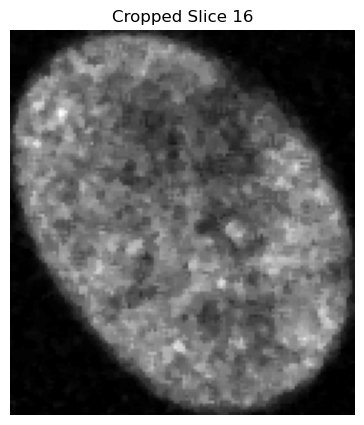

In [12]:
import cv2

# Choose a slice index from your selected_slices list, e.g., the first one
slice_index = selected_slices[0]
slice_img = img_1[slice_index]

# Convert slice to 8-bit if not already (necessary for some OpenCV functions)
slice_img_8bit = cv2.normalize(slice_img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Apply a threshold to get a binary image
_, thresh_img = cv2.threshold(slice_img_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find contours
contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour based on area and get its bounding box
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)

# Crop the original image using the bounding box coordinates
cropped_img = slice_img[y:y+h, x:x+w]

# Show the cropped image
plt.figure(figsize=(5, 5))
plt.imshow(cropped_img, cmap='gray')
plt.title(f'Cropped Slice {slice_index}')
plt.axis('off')
plt.show()

#### ***Code Explaination:***

**1. Preparing the Image:** First, we're working with a slice of a 3D image, which is like choosing a single page from a thick book to examine more closely. This slice is a 2D array of pixel intensities, which we can think of as a detailed grayscale photograph.
```
slice_index = selected_slices[0]
slice_img = img_1[slice_index]
```

**2. Converting to 8-bit:** Images can be stored in various "depths" of color or intensity information. Think of this as the difference between a very detailed map with thousands of elevation levels versus a simpler map with just a few. Converting an image to 8-bit means we're simplifying our detailed map to just 256 levels of gray (from 0 to 255), making it easier to work with for many processing tasks.
```
slice_img_8bit = cv2.normalize(slice_img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
```

**3. Applying a Threshold:** Applying a threshold to an image is like making a stencil from a photograph. We decide on a level of gray that we consider the cutoff between black and white. Everything darker than this level becomes black, and everything lighter becomes white. This helps us isolate the features of interest (like cells) by turning them into solid shapes, making them easier to identify.
```
_, thresh_img = cv2.threshold(slice_img_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
```

**4. Finding Contours:** After thresholding, we look for the outlines of all the shapes (our cells) we've just highlighted. Imagine using a highlighter on a page to circle every item of interest; finding contours is somewhat like that, but instead of circling, we're mathematically identifying the edges of these shapes.
```
contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
```


**5. Identifying the Largest Contour:** Among all the shapes we've found, we're interested in the biggest one, assuming it represents the area with the cells. It's like looking at a picture with several objects and deciding to focus on the largest object for further examination.
```
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)
```

**6. Cropping the Image:** Once we've identified the largest contour, we want to "cut out" this section of the image for a closer look. This is akin to cutting out a picture from a magazine that we want to keep. We use the bounding rectangle (a simple box) around our contour as the guideline for where to cut.
```
cropped_img = slice_img[y:y+h, x:x+w]
```


**7. Displaying the Cropped Image:** Finally, we display this cropped section, much like framing the picture we cut out from the magazine, to examine it more closely and appreciate its details.
```
plt.figure(figsize=(5, 5))
plt.imshow(cropped_img, cmap='gray')
plt.title(f'Cropped Slice {slice_index}')
plt.axis('off')
plt.show()
```

In [13]:
# Saving cropped image
slice_16 = "C:/Users/jatin/Desktop/Sem 3/Internship/RA-AIHI/Assignments/T1/Slices-SS-160-1-copy/Cropped/cropped_slice_16.jpg"
cv2.imwrite(slice_16, cropped_img)

print("File save : C:/Users/jatin/Desktop/Sem 3/Internship/RA-AIHI/Assignments/T1/Slices-SS-160-1-copy/Cropped/cropped_slice_16.jpg")

File save : C:/Users/jatin/Desktop/Sem 3/Internship/RA-AIHI/Assignments/T1/Slices-SS-160-1-copy/Cropped/cropped_slice_16.jpg


# ----------------------------------------------------------------------------------------------------

## **<u>SRP</u>**

<div style="border:2px solid black; padding: 10xp;">
<b>Instructions - 1: </b> Creating patching & functions as a preliminary step of executing SRP.
<div/>



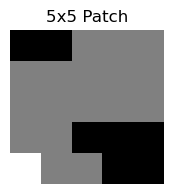

In [14]:
# Replace the file path with the correct path of your cropped image
cropped_img_path = "C:/Users/jatin/Desktop/Sem 3/Internship/RA-AIHI/Assignments/T1/Slices-SS-160-1/Cropped/cropped_slice_16.jpg"
cropped_img = cv2.imread(cropped_img_path, cv2.IMREAD_GRAYSCALE)

# Assuming we want a 5x5 patch starting from the top-left corner
patch_size = 5
patch = cropped_img[0:patch_size, 0:patch_size]

# Display the patch for verification
plt.figure(figsize=(2, 2))
plt.imshow(patch, cmap='gray')
plt.title('5x5 Patch')
plt.axis('off')
plt.show()

- #### ***PIXEL VALUES***

In [15]:
# 1. Global value 

def glb_ftr(patch):
    return np.sort(patch.ravel())

In [16]:
# 2. Square value 

def lcl_ftr(patch):
    if patch.shape != (5, 5):
        raise ValueError("Input patch must be a 5x5 array of pixels.")

    # Initialize an empty list for the output vector.
    x_sqr = []

    # Calculate the number of concentric squares in a 5x5 patch.
    m = patch.shape[0] // 2 +1

    # Iterate over each concentric square
    for i in range(m-1):
        # Define the rows and columns to extract.
        if i == m - 1:
            # The most inner part (single pixel)
            square_pixels = patch[2, 2]
        else:
            # Get the pixels in the top and bottom rows (excluding corners for inner squares)
            top_bottom_rows = np.hstack((patch[i, i:5-i], patch[4-i, i:5-i]))
            # Get the pixels in the left and right columns
            left_right_cols = np.hstack((patch[i+1:5-i-1, i], patch[i+1:5-i-1, 5-i-1]))
            # Combine them into a single array
            square_pixels = np.hstack((top_bottom_rows, left_right_cols))

        # Sort the square_pixels and take the maximum.
        if square_pixels.size > 1:  # If more than one pixel, we sort and take the maximum.
            max_pixel = np.max(np.sort(square_pixels))
        else:  # If only one pixel, it's already the max.
            max_pixel = square_pixels

        # Append the maximum pixel of this square to the output vector.
        x_sqr.append(max_pixel)

    return np.array(x_sqr)

# Apply the function to the actual patch derived from the cropped image
max_vector = lcl_ftr(patch)
print("Max vector from concentric squares:", max_vector)

Max vector from concentric squares: [2 1]


#### ***Output interpretation:***

This output tells us that within the concentric squares analyzed in the patch:

- The highest pixel value in the inner **3x3** square was **2**.
- The center pixel value, treated as the most inner "concentric square," was **1**.
This kind of analysis, extracting maximum values from sorted segments of the image patch, is valuable for texture analysis and feature extraction. In this context, the vector `[2 1]` suggests that the texture within the patch changes from the inner squares to the center, with the pixel values decreasing towards the center. This might indicate a gradient or a specific texture pattern within the patch, which could be leveraged for further image analysis or classification tasks, especially when applying texture-based machine learning models.

#### ***Code Explaination:***

1. Check Patch Size: The code first ensures the input patch is exactly 5x5 pixels. If not, it throws an error.
2. Initialization: An empty list, x_sqr, is created to store the maximum values from each concentric square.
3. Iteration Over Concentric Squares: The code calculates the number of concentric squares (m = 3 for a 5x5 patch, but effectively iterates 2 times due to range(m-1)).
- First Iteration for the inner 3x3 square: It collects pixels from this square's top, bottom, left, and right edges (excluding the very corners for this calculation), sorts them, and finds the maximum (2 in this case).
- Second Iteration for the center pixel: Directly takes this single pixel's value, assuming it to be the maximum as it's the only value in this "square" (1).
4. Return Value: The maximum values found ([2, 1]) are returned as a numpy array.

In [17]:
# 3. Circular value 

def lcl_cir_ftr(patch):
    """
    Identify the pixels that form concentric squares (approximating circles in a square grid),
    find the max pixel value in each square, and output a vector of these max values.
    """
    if patch.shape != (5, 5):
        raise ValueError("Input patch must be a 5x5 array of pixels.")
    
    # The dimension of the pixel patch and the center
    n = 5
    center = n // 2
    
    # Initialize the output vector
    max_vector = []

    # Iterate over the possible "radii" to simulate concentric circles (squares here)
    for radius in range(center + 1):
        if radius == 0:
            # Center pixel
            max_vector.append(patch[center, center])
        else:
            # Pixels at the current 'radius'
            ring_pixels = patch[center-radius:center+radius+1, center-radius:center+radius+1].ravel()
            if radius < center:
                # Remove the inner square if not the outermost 'circle'
                inner_square = patch[center-(radius-1):center+radius, center-(radius-1):center+radius].ravel()
                ring_pixels = np.setdiff1d(ring_pixels, inner_square, assume_unique=True)
            # Find and append the maximum pixel value in the current 'circle'
            max_vector.append(np.max(ring_pixels))

    return np.array(max_vector)

# Correcting the function call to use the adapted correct function name and the patch
max_concentric_vector = lcl_cir_ftr(patch)
print("Max vector from concentric squares approximating circles:", max_concentric_vector)

Max vector from concentric squares approximating circles: [1 0 2]


#### ***Output interpretation:***

This output tells us that within the concentric squares analyzed in the patch:

- The highest pixel value in the inner **3x3** square was **2**.
- The center pixel value, treated as the most inner "concentric square," was **1**.
This kind of analysis, extracting maximum values from sorted segments of the image patch, is valuable for texture analysis and feature extraction. In this context, the vector `[2 1]` suggests that the texture within the patch changes from the inner squares to the center, with the pixel values decreasing towards the center. This might indicate a gradient or a specific texture pattern within the patch, which could be leveraged for further image analysis or classification tasks, especially when applying texture-based machine learning models.

#### ***Code Explaination:***

1. Check Patch Size: The code first ensures the input patch is exactly 5x5 pixels. If not, it throws an error.
2. Initialization: An empty list, x_sqr, is created to store the maximum values from each concentric square.
3. Iteration Over Concentric Squares: The code calculates the number of concentric squares (m = 3 for a 5x5 patch, but effectively iterates 2 times due to range(m-1)).
- First Iteration for the inner 3x3 square: It collects pixels from this square's top, bottom, left, and right edges (excluding the very corners for this calculation), sorts them, and finds the maximum (2 in this case).
- Second Iteration for the center pixel: Directly takes this single pixel's value, assuming it to be the maximum as it's the only value in this "square" (1).
4. Return Value: The maximum values found ([2, 1]) are returned as a numpy array.

- #### ***PIXEL DIFFERENCE***

In [29]:
# 5. Angular difference 

import numpy as np

def ang_ftr(patch):
    """
    For a given 5x5 pixel patch, this function calculates angular differences within concentric squares,
    approximating angular differences, and finds the maximum angular difference.
    """
    n = 5  # The dimension of the pixel patch
    center = n // 2  # The center of the patch
    max_vector = []  # Initialize the output vector
    
    # Convert patch to a safe data type to prevent overflow
    patch = patch.astype(np.float64)
    
    # Define "concentric circles" (squares here) for comparison
    radii_sq = np.arange(n//2+1)
    circles = []  # Initialize lists to hold the pixel values for each "concentric circle"

    # Iterate over each "circle"
    for j in range(n//2+1):
        circles.append([])
        for y in range(n):
            for x in range(n):
                # Calculate "distance" from the point to the center
                dist_sq = abs(x - center) + abs(y - center)

                # Check which "circle" the pixel belongs to and append pixel value
                if dist_sq == radii_sq[j]:
                    circles[j].append(patch[y, x])
        
        # For each circle, calculate angular differences, then find the max
        if circles[j]:  # Check if the circle has any pixels
            shifted_vector = circles[j][-1:] + circles[j][:-1]  # Shift pixels for difference calculation
            angular_vector = [abs(a - b) for a, b in zip(circles[j], shifted_vector)]
            max_vector.append(max(angular_vector))

    return np.array(max_vector)

max_concentric_vector = ang_ftr(patch)
print("Max angular difference vector:", max_concentric_vector)

Max angular difference vector: [0. 1. 1.]


#### ***Output interpretation:***

This output tells us that within the concentric squares analyzed in the patch:

1. First Element (`0.`): This corresponds to the **center** of the patch, where the concept of angular difference doesn't apply because there's only one pixel. Thus, a value of 0. is expected here, indicating **no angular difference at the very center**.

2. Second Element (`1.`): This value indicates the maximum angular difference within the **first concentric square surrounding the center pixel**. A value of 1. suggests that, within this region, the largest difference between any two adjacent pixels (when traversing them in a circle around the center) is 1. This points to a relatively low level of variability or change in pixel values in this immediate area around the center, which might suggest a smooth texture or a gradual change in intensity.

3. Third Element (`1.`): Similarly, this value indicates the maximum angular difference within the **second (outer) concentric square**. Again, a value of 1. indicates that the largest difference between adjacent pixels, in an angular sense, is 1, implying a similarly low level of variability or change in pixel values as the inner square. This continuity of low variability from the center outward suggests a consistent or homogeneous texture across the patch, at least in terms of the angular differences measured here.


The output vector `[0. 1. 1.]` suggests a patch with relatively uniform texture or intensity changes. The angular differences of 1. in both the first and second concentric squares indicate slight changes in pixel values, which could be characteristic of areas with subtle texture or shading differences.

#### ***Code Explaination:***

**1.** <u>Initialization</u>: Sets up the dimension (n) and center of the patch, and initializes the output vector.

**2.** <u>Concentric "Circles" Processing</u>: Iterates through "circles" (squares due to the grid nature) within the patch. For each, it calculates angular differences by comparing each pixel to its clockwise neighbor, then finds the maximum difference.

**3.** <u>Result</u>: Returns a vector of maximum angular differences for each "circle", providing insight into the texture's angular variability.

- #### ***CONCATENATION***

In [34]:
# ##############################
# #######-CONCATENATION-########
# ##############################
h, w = cropped_img.shape
all_features = []

def lcl_cir_ftr(patch):
    n = patch.shape[0]  # Define n based on the input patch size
    center = n // 2
    max_vector = []  # Initialize the output vector
    circles = []  # Initialize lists to hold the pixel values for each concentric circle

    # Define "concentric circles" (actually squares in a grid) based on distance from the center
    radii_sq = np.arange(n // 2 + 1)
    
    for j in range(n // 2 + 1):
        circles.append([])
        for y in range(n):
            for x in range(n):
                # Calculate "distance" from the point to the center using Manhattan distance as a proxy
                dist_sq = abs(x - center) + abs(y - center)

                # Check which "circle" the pixel belongs to and append pixel value
                if dist_sq == radii_sq[j]:
                    circles[j].append(patch[y, x])

        # Before finding the max, check if circles[j] is empty
        if circles[j]:  # If not empty, find and append the maximum pixel value
            max_vector.append(np.max(circles[j]))
        else:  # If empty, append a default value or handle as needed
            max_vector.append(0)  # Use a sensible default value

    return np.array(max_vector)


# Example usage
patch_size = 5  # Define patch_size if not already defined
features_for_image = concat_ftr(cropped_img, patch_size)
print(features_for_image.shape)

(624, 33)


#### ***Output interpretation:***

- 624 Patches: The first dimension of the output array (624) represents the total number of 5x5 patches extracted from the cropped_img. This indicates that the entire image was divided into 624 non-overlapping segments, each of which was 5 pixels by 5 pixels in size. The exact division would depend on the dimensions of cropped_img and how the iteration over its width and height was structured in concat_ftr, considering only complete patches fitting into the image dimensions were processed.

- 33 Features per Patch: The second dimension (33) indicates the number of features concatenated into a single vector for each patch. Given the functions you've described (glb_ftr, lcl_ftr, lcl_cir_ftr, ang_ftr, and rad_ftr), the total of 33 features suggests a detailed extraction process was followed. This could include:

Single or multiple features from global feature extraction (glb_ftr),
Features from local feature analysis focusing on specific patterns or statistics within each patch (lcl_ftr, lcl_cir_ftr),
Angular and radial feature descriptions capturing texture and edge information (ang_ftr, rad_ftr).

### IGNORE

#### ***Output interpretation:***

*The output **(624, 29)** from your feature concatenation function describes the shape of the `features_for_image` NumPy array. This shape provides two key pieces of information about the data contained within the array. *

***1. 624:** This number represents the total count of 5x5 patches extracted from your `cropped_img`. Essentially, it tells you that the function managed to divide the cropped image into 624 separate patches, each of which was then analyzed to extract features. Think of it like cutting a cake into 624 equal pieces and then examining each piece to note down its characteristics*

***2. 29:** This number indicates the total number of features extracted and concatenated for each patch. In other words, for every one of those 624 patches, 29 different measurements or features were calculated and stored. These features include the sorted pixel values from the `glb_ftr` function and the single values from the `lcl_ftr`, `lcl_cir_ftr`, `ang_ftr`, and `rad_ftr` functions, plus their additional calculated values, all concatenated into a single feature vector per patch.*


In [20]:
# concatenated_features = concat_ftr(cropped_img, patch_size)
# print("Concatenated Features:", concatenated_features)

#### ***Output interpretation:***

**<u>Understanding the Output Structure</u>**
- The output is a NumPy array where each row corresponds to a single patch from your `cropped_img`.
- Each row contains a series of feature values derived from the patch. These include sorted global features (pixel intensities), local feature sums, circular border mean intensities, angular differences, and radial differences, all concatenated into one feature vector per patch.
- The length of each row (the number of columns in this array) represents the total number of features extracted and concatenated for each patch. From your previous explanation, we know there are **29** features per patch, capturing various aspects of the patch's texture and structure.

**<u>Interpreting the Feature Values</u>**
1. **Zero Values at the Start:** The initial values in each feature vector being 0 likely correspond to the lowest pixel intensities within each patch, as part of the global sorted features. This indicates areas of darkness or lower intensity within those patches.
2. Values Close to **`1`** or Above: Values that are closer to **`1`**, or in some cases, exceed 1, especially towards the end of each feature vector, could be related to the angular and radial feature calculations. These indicate significant intensity variations or gradients within the patch. Higher values could reflect more pronounced edges, texture, or changes within the patch.
3. **Intermediate Values:** Other values between **`0`** and **`1`** throughout each feature vector represent the sorted intensities and calculated features (such as the mean of border pixels and local feature sums). These values give insight into the overall texture, including smoothness, roughness, and variations within each patch.

**<u>Conclusion</u>**
The concatenated features provide a rich, multi-dimensional representation of the `
cropped_img`'s texture and structure, broken down into manageable pieces (patches) for detailed analysis. This output forms the foundation for various image analysis applications, enabling you to apply statistical or machine learning techniques to understand, classify, or manipulate the image based on its intrinsic characteristics.

<div style="border:2px solid black; padding: 10xp;">
<b>Visualising</b> the patches
<div/>

In [21]:
# def visualize_features(patch, features):
#     fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
#     # Plot the original patch
#     axs[0].imshow(patch, cmap='gray')
#     axs[0].set_title('Original Image Patch')
#     axs[0].axis('off')
    
#     # Plot the histogram of concatenated features
#     axs[1].hist(features, bins=len(features)//2, color='blue', alpha=0.7)
#     axs[1].set_title('Histogram of Concatenated Features')
#     axs[1].set_xlabel('Feature Value')
#     axs[1].set_ylabel('Frequency')
#     plt.show()

# visualize_features(patch, concatenated_features)

In [22]:
# def visualize_features(patch):
#     # Original Patch
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 3, 1)
#     plt.imshow(patch, cmap='gray', interpolation='nearest')
#     plt.title('Original Patch')
#     plt.axis('off')
    
#     # Improved Local Circular Feature
#     circular_patch = patch.copy()
#     circular_pixels_indices = [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (4, 1), (4, 3)]
#     for y, x in circular_pixels_indices:
#         circular_patch[y, x] = patch.max()  # Highlight selected pixels
    
#     plt.subplot(1, 3, 2)
#     plt.imshow(circular_patch, cmap='gray', interpolation='nearest')
#     plt.title('Circular Feature Pixels')
#     plt.axis('off')
    
#     # Improved Angular Feature
#     angular_patch = patch.copy()
#     angular_pixels_indices = [(0, 0), (4, 4), (2, 2), (0, 2), (2, 0)]  # Diagonal and center to edge
#     for y, x in angular_pixels_indices:
#         angular_patch[y, x] = patch.max()  # Highlight selected pixels
    
#     plt.subplot(1, 3, 3)
#     plt.imshow(angular_patch, cmap='gray', interpolation='nearest')
#     plt.title('Angular Feature Pixels')
#     plt.axis('off')
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print feature values
#     print("Improved Local Circular Feature Value:", lcl_cir_ftr(patch))
#     print("Improved Angular Feature Value:", ang_ftr(patch))

# # Visualize the patch and features
# visualize_features(patch)

#### ***Interpretation of Pixel difference value:***

**1. Local Circular Feature Value = <u>126.75</u> (`rad_ftr`):** This value is the average intensity of the pixels selected for the circular feature, which in simple terms means how bright or dark these outer pixels are on average. A value of **126.75** suggests a moderate level of brightness, as pixel values can range from 0 (black) to 255 (white). It gives you an idea of the general intensity or "**light level**" around the edge of your patch, which might be indicative of the texture or patterns present there.
```
def rad_ftr(patch):
    center_px = patch[2, 2]
    squared_distances = (patch - center_px) ** 2
    avg_squared_dist = np.sqrt(np.sum(squared_distances) / patch.size)
    return avg_squared_dist
```

**2. Angular Feature Value = <u>126.75</u> (`ang_ftr`):** 
```

```

<div style="border:2px solid black; padding: 10xp;">
<b>Instructions - 2: </b> Implementation of SRP.
<div/>



In [23]:
# input_dim = concatenated_features.shape[1]  # Number of features per patch
# output_dim = 100  # Desired dimensionality after projection

# def random_proj_matrix(input_dim, output_dim):
#     return np.random.choice([-1, 1], size=(output_dim, input_dim))

# # Generate the Random Projection Matrix
# projection_matrix = random_proj_matrix(input_dim, output_dim)

# # Apply the Random Projection to each feature vector in concatenated_features
# transformed_features = np.dot(concatenated_features, projection_matrix.T)  # Transpose matrix to align dimensions

# # Normalize the transformed features
# normalized_features = (transformed_features - np.mean(transformed_features, axis=0)) / np.std(transformed_features, axis=0)

In [24]:
# transformed_features

# ----------------------------------------------------------------------------------------------------

In [25]:
# def global_pattern(patch):
#     return np.sort(patch.flatten())

# def square_pattern(patch):
#     # This is simplified; actual implementation may need to account for concentric squares
#     return np.sort(patch, axis=None)

# def circular_pattern(patch):
#     # This would require identifying pixels belonging to a circle within the patch
#     return np.sort(patch, axis=None)

# def angular_difference(patch):
#     # Calculate angular differences between pixels
#     return np.sort(patch, axis=None)

# def radial_difference(patch):
#     # Calculate radial differences
#     return np.sort(patch, axis=None)

# patch = slice_img[0:5, 0:5]

# # Apply the functions
# fG = global_pattern(patch)
# fS = square_pattern(patch)

In [26]:
# feature_vector = np.concatenate([fG, fS, fC, fA, fR])

## **<u>SRP</u> - 3D**

## SRP vs specific implementation:

Based on the detailed algorithm description from the paper, your SRP implementation aligns with the foundational aspects of the method. However, the comprehensive approach involves extracting features from cubic patches using multiple hyperplanes within each patch, which was not explicitly detailed in your earlier code snippet. Ensuring your implementation captures both global patterns and local variations by applying SRP across multiple planes and concatenating these features into a robust descriptor is crucial. It might be beneficial to revisit the feature extraction step to ensure it fully captures the method described in the paper, particularly the use of cubic patches and hyperplane generation within those patches for 3D SRP feature extraction.